In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import vmap, jit
import jax.numpy as jnp
from pathlib import Path
import numpy as np
from einops import rearrange
import jax
import matplotlib.pyplot as plt
import seaborn as sns
from hflow.misc.plot import scatter_movie, imshow_movie
from jax import grad, vmap, value_and_grad
from hflow.run import build
from hflow.config import Config, Sample
from functools import partial
from hflow.train.adam import adam_opt
from hflow.train.sample import get_arg_fn

from hflow.run import build
from hflow.config import Config, Sample, Loss, Data, Network
from hflow.train.loss import OV_Loss

In [3]:
from hflow.config import vlasov_config
cfg =  Config(problem='vtwo',
            data=Data(t_end=40, n_samples=10_000, dt=1e-2),
            sample=Sample(bs_n=128, bs_t=128),
            unet=Network(model='colora')
            )
key, train_data, test_data, loss_fn, arg_fn, s_fn, params_init = build(cfg)

In [4]:

arg_fn_gauss = get_arg_fn(Sample(scheme_t='gauss', bs_t=128), train_data)
last_params, opt_params, loss_history, param_history_gauss = adam_opt(params_init, loss_fn, arg_fn_gauss, steps=2000, learning_rate=2e-3, verbose=True, scheduler=True, key=key, return_params=True)



adam:   0%|          | 0/2000 [00:00<?, ?it/s]

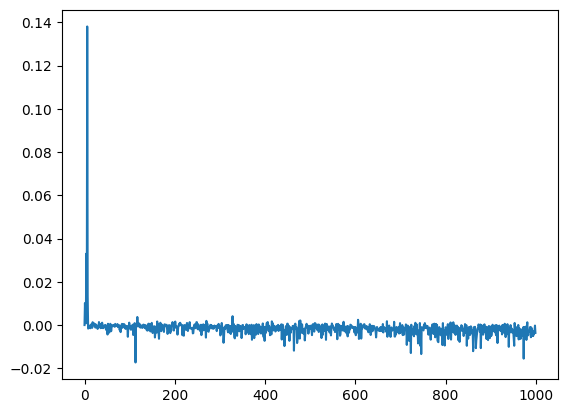

In [5]:
plt.plot(loss_history)
plt.show()

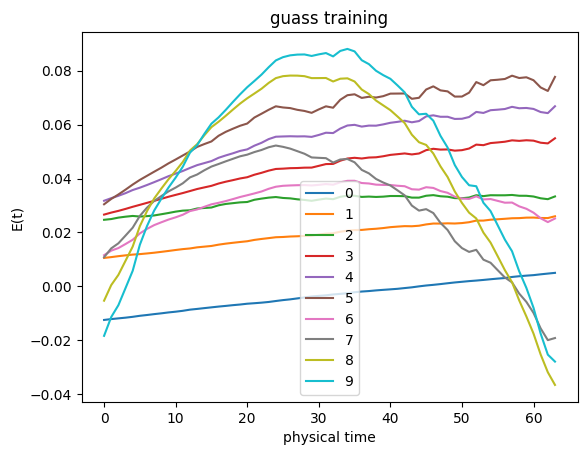

In [6]:


arg_fn_equi = get_arg_fn(Sample(scheme_t='equi', bs_t=64), train_data)
loss_fn2 = OV_Loss(s_fn, noise=0.0, sigma=0.0, return_interior=True)
loss_data = arg_fn_equi(key, None)
interiors_gauss = []
for i, p in enumerate(param_history_gauss[::100]):
    loss, interior = loss_fn2(p, *loss_data, key)
    interiors_gauss.append(interior)
    plt.plot(interior, label=i)

interiors_gauss = np.asarray(interiors_gauss)
plt.ylabel('E(t)')
plt.xlabel('physical time')
plt.legend()
plt.title('guass training')
plt.show()

In [7]:

arg_fn_rand = get_arg_fn(Sample(scheme_t='rand', bs_t=128), train_data)
last_params, opt_params, loss_history, param_history_rand = adam_opt(params_init, loss_fn, arg_fn_rand, steps=2000, learning_rate=2e-3, verbose=True, scheduler=True, key=key, return_params=True)



adam:   0%|          | 0/2000 [00:00<?, ?it/s]

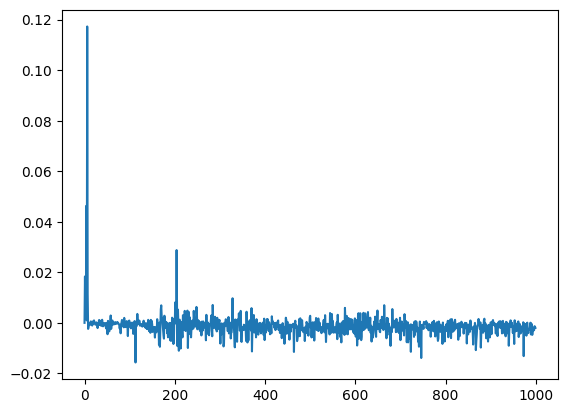

In [8]:
plt.plot(loss_history)
plt.show()

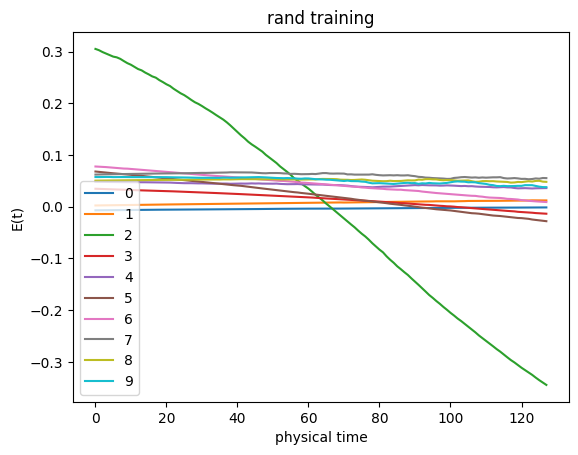

In [9]:


arg_fn_equi = get_arg_fn(Sample(scheme_t='equi', bs_t=128), train_data)
loss_fn2 = OV_Loss(s_fn, noise=0.0, sigma=0.0, return_interior=True)

interiors_gauss = []
for i, p in enumerate(param_history_rand[::100]):
    key, _ = jax.random.split(key)
    loss_data = arg_fn_equi(key, None)
    loss, interior = loss_fn2(p, *loss_data, key)
    interiors_gauss.append(interior)
    plt.plot(interior, label=i)

interiors_gauss = np.asarray(interiors_gauss)
plt.ylabel('E(t)')
plt.xlabel('physical time')
plt.legend()
plt.title('rand training')
plt.show()

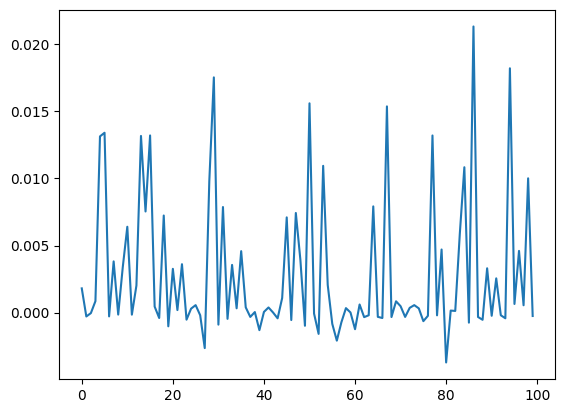

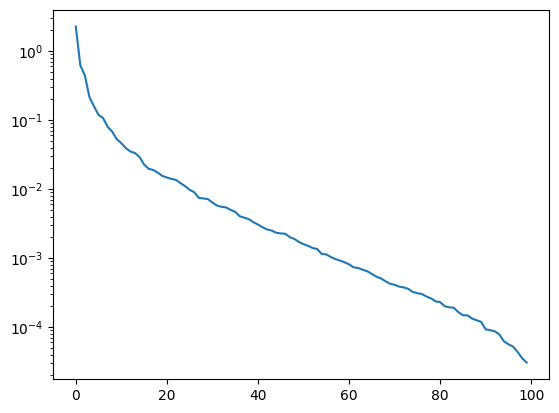

In [10]:
iters = 100
key = jax.random.PRNGKey(np.random.randint(0,1e5))
keys = jax.random.split(key, num=iters)

@jit
def do_loss(key, params):
    data = arg_fn_rand(key, None)
    loss, grad_loss = value_and_grad(loss_fn)(params, *data, key)
    grad_loss = jax.flatten_util.ravel_pytree(grad_loss)[0]
    return loss, grad_loss

losses, grads = [], []
for k in keys:
    l, g = do_loss(k, params_init)
    losses.append(l)
    grads.append(g)
losses_rand = np.asarray(losses)
grads = np.asarray(grads)

plt.plot(losses_rand)
plt.show()
u, s, vt = jnp.linalg.svd(grads)
plt.semilogy(s)
plt.show()

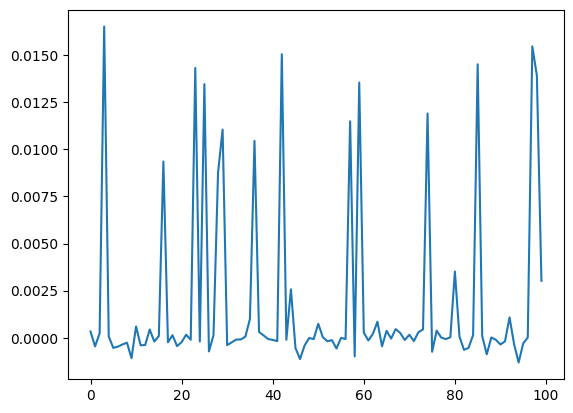

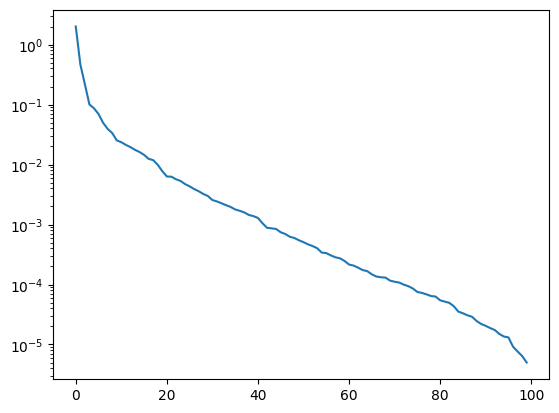

In [11]:
iters = 100
key = jax.random.PRNGKey(np.random.randint(0,1e5))
keys = jax.random.split(key, num=iters)

@jit
def do_loss(key, params):
    data = arg_fn_gauss(key, None)
    loss, grad_loss = value_and_grad(loss_fn)(params, *data, key)
    grad_loss = jax.flatten_util.ravel_pytree(grad_loss)[0]
    return loss, grad_loss

losses, grads = [], []
for k in keys:
    l, g = do_loss(k, params_init)
    losses.append(l)
    grads.append(g)
losses_gauss = np.asarray(losses)
grads = np.asarray(grads)

plt.plot(losses_gauss)
plt.show()
u, s, vt = jnp.linalg.svd(grads)
plt.semilogy(s)
plt.show()

In [12]:
from hflow.run import build
from hflow.config import Config, Sample

cfg = Config(problem='osc', sample=Sample(scheme_t='gauss', bs_t=128))
_, _, loss_fn, arg_fn_gauss, s_fn, params_init = build(cfg)

@jit
def do_loss(key):
    data = arg_fn_gauss(key)
    loss, grad_loss = value_and_grad(loss_fn)(last_params, *data, key)
    grad_loss = jax.flatten_util.ravel_pytree(grad_loss)[0]
    return loss, grad_loss

losses, grads = [], []
for k in keys:
    l, g = do_loss(k)
    losses.append(l)
    grads.append(g)
losses_gauss = np.asarray(losses)
grads = np.asarray(grads)

u, s, vt = jnp.linalg.svd(grads)
s_gauss = s/s[0]
v_gauss = np.var(losses_gauss/ np.linalg.norm(losses_gauss))

UnboundLocalError: local variable 'train_mus' referenced before assignment

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

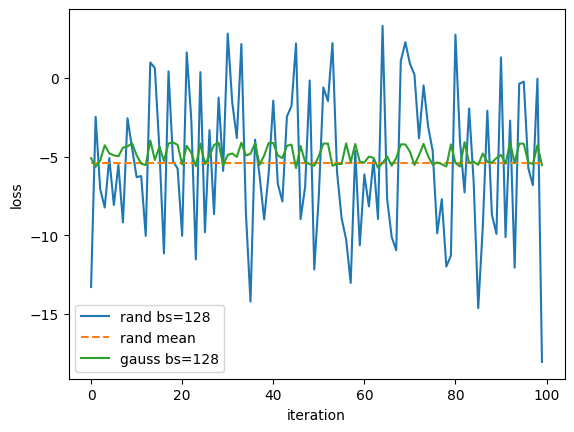

In [ ]:
o = np.ones_like(losses_rand)
plt.plot(losses_rand, label='rand bs=128')
plt.plot(o*np.mean(losses_rand), '--',  label='rand mean')
plt.plot(losses_gauss, label='gauss bs=128')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

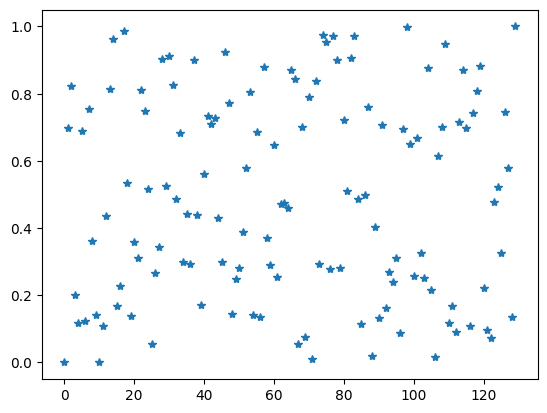

In [ ]:
sol, mu, t, q = arg_fn_rand(key)
plt.plot(t, '*')
plt.show()

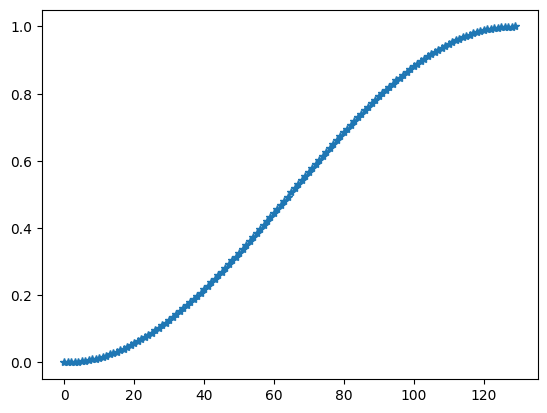

In [ ]:
sol, mu, t, q = arg_fn_gauss(key)
plt.plot(t, '*')
plt.show()

In [ ]:
np.sum(q)

Array(1., dtype=float32)

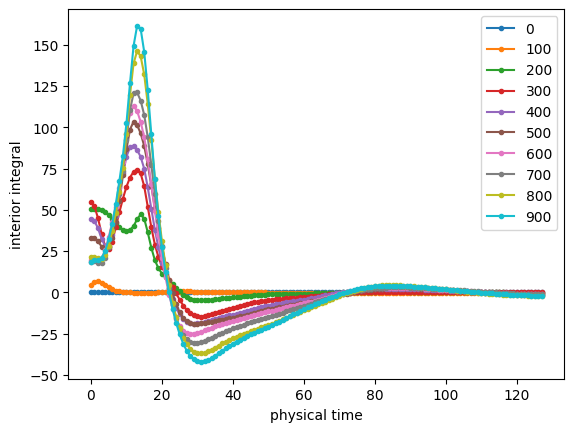

In [ ]:

loss_fn = Action_Match(s_fn, noise=0.0, sigma=0.0, return_interior=True)
data = arg_fn_equi(key)
loss, interior = loss_fn(last_params, *data, key)
plt.plot(interior, '.-')
plt.show()